##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 图像分割

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    在 tensorFlow.google.cn 上查看</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    在 Google Colab 中运行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    在 GitHub 上查看源代码</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />下载 notebook</a>
  </td>
</table>

这篇教程将重点讨论图像分割任务，使用的是改进版的 [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)。

## 什么是图像分割？
目前你已经了解在图像分类中，神经网络的任务是给每张输入图像分配一个标签或者类别。但是，有时你想知道一个物体在一张图像中的位置、这个物体的形状、以及哪个像素属于哪个物体等等。这种情况下你会希望分割图像，也就是给图像中的每个像素各分配一个标签。因此，图像分割的任务是训练一个神经网络来输出该图像对每一个像素的掩码。这对从更底层，即像素层级，来理解图像很有帮助。图像分割在例如医疗图像、自动驾驶车辆以及卫星图像等领域有很多应用。

本教程将使用的数据集是 [Oxford-IIIT Pet 数据集](https://www.robots.ox.ac.uk/~vgg/data/pets/)，由 Parkhi *et al.* 创建。该数据集由图像、图像所对应的标签、以及对像素逐一标记的掩码组成。掩码其实就是给每个像素的标签。每个像素分别属于以下三个类别中的一个：
*   类别 1：像素是宠物的一部分。
*   类别 2：像素是宠物的轮廓。  # 此处有误，应该3是轮廓
*   类别 3：以上都不是/外围像素。 

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /private/var/folders/t1/3d1fbx5s1k1bf15gl15h04mc0000gn/T/pip-req-build-sn56rsb5
  Running command git clone -q https://github.com/tensorflow/examples.git /private/var/folders/t1/3d1fbx5s1k1bf15gl15h04mc0000gn/T/pip-req-build-sn56rsb5


In [1]:
import tensorflow as tf

In [96]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

## 下载 Oxford-IIIT Pets 数据集

这个数据集已经集成在 Tensorflow datasets 中，只需下载即可。图像分割掩码在版本 3.0.0 中才被加入，因此我们特别选用这个版本。

In [6]:
dataset, info = tfds.load('oxford_iiit_pet:3.0.0', with_info=True)

Shuffling and writing examples to /Users/user/tensorflow_datasets/oxford_iiit_pet/3.0.0.incompleteWZFWBM/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /Users/user/tensorflow_datasets/oxford_iiit_pet/3.0.0.incompleteWZFWBM/oxford_iiit_pet-test.tfrecord


W0420 15:14:34.469092 4736599488 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.
W0420 15:14:40.745106 4736599488 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


Dataset oxford_iiit_pet downloaded and prepared to /Users/user/tensorflow_datasets/oxford_iiit_pet/3.0.0. Subsequent calls will reuse this data.


下面的代码进行了一个简单的图像翻转扩充。然后，将图像标准化到 [0,1]。最后，如上文提到的，像素点在图像分割掩码中被标记为 {1, 2, 3} 中的一个。为了方便起见，我们将分割掩码都减 1，得到了以下的标签：{0, 1, 2}。 

In [10]:
a = dataset['test'].take(2)

In [12]:
list(a.as_numpy_iterator())[0]['image'].shape

(500, 403, 3)

In [87]:
mask = list(a.as_numpy_iterator())[0]['segmentation_mask']

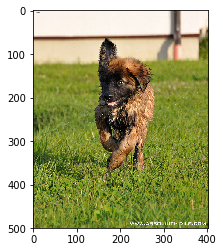

In [19]:
plt.imshow(list(a.as_numpy_iterator())[0]['image'])

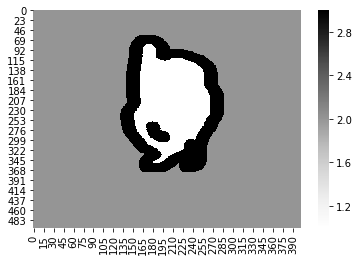

In [90]:
sns.heatmap(mask[:,:,0], cmap=plt.cm.Greys)

In [7]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32)/255.0
  input_mask -= 1
  return input_image, input_mask

In [20]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [21]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

数据集已经包含了所需的测试集和训练集划分，所以我们也延续使用相同的划分。

In [22]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [26]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [27]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

我们来看一下数据集中的一例图像以及它所对应的掩码。

In [28]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

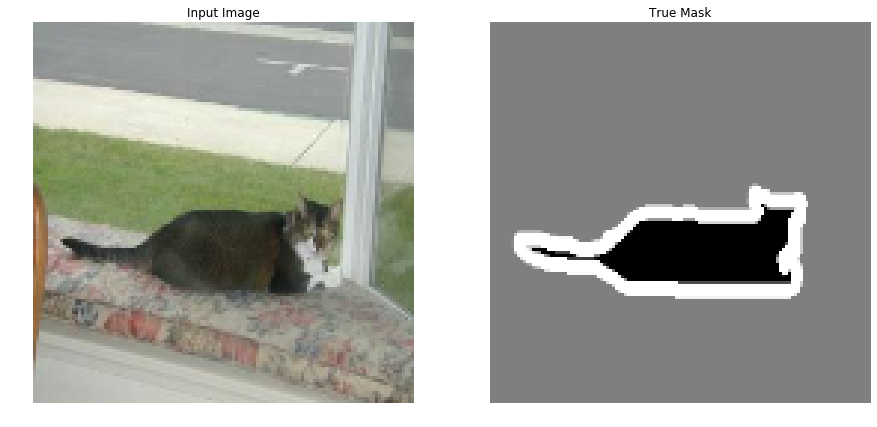

In [29]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## 定义模型
这里用到的模型是一个改版的 U-Net。U-Net 由一个编码器（下采样器（downsampler））和一个解码器（上采样器（upsampler））组成。为了学习到鲁棒的特征，同时减少可训练参数的数量，这里可以使用一个预训练模型作为编码器。因此，这项任务中的编码器将使用一个预训练的 MobileNetV2 模型，它的中间输出值将被使用。解码器将使用在 TensorFlow Examples 中的 [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) 里实施过的升频取样模块。  

输出信道数量为 3 是因为每个像素有三种可能的标签。把这想象成一个多类别分类，每个像素都将被分到三个类别当中。

In [97]:
OUTPUT_CHANNELS = 3

如之前提到的，编码器是一个预训练的 MobileNetV2 模型，它在 [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications) 中已被准备好并可以直接使用。编码器中包含模型中间层的一些特定输出。注意编码器在模型的训练过程中是不会被训练的。

In [98]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# 使用这些层的激活设置
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 创建特征提取模型
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 17s 2us/step


In [116]:
for i in layer_names:
    print(base_model.get_layer(i).output)

Tensor("block_1_expand_relu/Identity:0", shape=(None, 64, 64, 96), dtype=float32)
Tensor("block_3_expand_relu/Identity:0", shape=(None, 32, 32, 144), dtype=float32)
Tensor("block_6_expand_relu/Identity:0", shape=(None, 16, 16, 192), dtype=float32)
Tensor("block_13_expand_relu/Identity:0", shape=(None, 8, 8, 576), dtype=float32)
Tensor("block_16_project/Identity:0", shape=(None, 4, 4, 320), dtype=float32)


解码器/升频取样器是简单的一系列升频取样模块，在 TensorFlow examples 中曾被实施过。

In [109]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [117]:
def unet_model(output_channels):

  # 这是模型的最后一层
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # 在模型中降频取样
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # 升频取样然后建立跳跃连接
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## 训练模型
现在，要做的只剩下编译和训练模型了。这里用到的损失函数是 losses.sparse_categorical_crossentropy。使用这个损失函数是因为神经网络试图给每一个像素分配一个标签，和多类别预测是一样的。在正确的分割掩码中，每个像素点的值是 {0,1,2} 中的一个。同时神经网络也输出三个信道。本质上，每个信道都在尝试学习预测一个类别，而 losses.sparse_categorical_crossentropy 正是这一情形下推荐使用的损失函数。根据神经网络的输出值，分配给每个像素的标签为输出值最高的信道所表示的那一类。这就是 create_mask 函数所做的工作。

In [118]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

我们试着运行一下模型，看看它在训练之前给出的预测值。

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [0]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [0]:
show_predictions()

我们来观察模型是怎样随着训练而改善的。为达成这一目的，下面将定义一个 callback 函数。

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [0]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

In [0]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## 做出预测

我们来做几个预测。为了节省时间，这里只使用很少的周期（epoch）数，但是你可以设置更多的数量以获得更准确的结果。

In [0]:
show_predictions(test_dataset, 3)

## 接下来
现在你已经对图像分割是什么以及它的工作原理有所了解。你可以在本教程里尝试使用不同的中间层输出值，或者甚至使用不同的预训练模型。你也可以去 Kaggle 举办的 [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) 图像分割挑战赛上挑战自己。

你也可以看看 [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) 上面其他的你可以使用自己数据进行再训练的模型。